# **1. Set up work directory**

In [0]:
# Mount Google Drive.
# Copy the authentication code into the input box.
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
BASE_DATA_DIR = "/content/drive/My\ Drive/Colab\ Notebooks/w266_project"
SQUAD_DATA_DIR = BASE_DATA_DIR + "/squad_2"
BERT_DATA_DIR = BASE_DATA_DIR + "/bert"

# output dir on Drive (as opposed the output dir on GCS bucket)
DRIVE_OUTPUT_DIR = BASE_DATA_DIR + "/model_output"

In [0]:
mkdir -p $SQUAD_DATA_DIR

In [0]:
mkdir -p $BERT_DATA_DIR

In [0]:
mkdir -p $DRIVE_OUTPUT_DIR

# **2. Download SQuAD 2.0 dataset**

In [0]:
cd $SQUAD_DATA_DIR

/content/drive/My Drive/Colab Notebooks/w266_project/squad_2


In [0]:
ls -l

total 0


In [0]:
#Download the SQUAD train and dev dataset
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2020-03-22 00:32:59--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  63.7MB/s    in 0.6s    

2020-03-22 00:33:00 (63.7 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2020-03-22 00:33:01--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       

In [0]:
ls -l

total 45405
-rw------- 1 root root  4370528 Mar 18 01:55 dev-v2.0.json
-rw------- 1 root root 42123633 Mar 18 01:55 train-v2.0.json


# **3. Split Answerable and non-Answerable Questions**

### **3.1 Structure of SQuAD data**

* **There is already a boolean field 'is_impossible' indicating the question is answerable or not.**
* The data contains many articles, each article contains many paragraphs, each paragraph contains many Q&A-s and the context.

```
{
  "version": "v2.0",
  "data": [
    {
      "title": "Normans",
      "paragraphs": [
        {
          "qas": [
            {
              "question": "In what country is Normandy located?",
              "id": "56ddde6b9a695914005b9628",
              "answers": [
                {
                  "text": "France",
                  "answer_start": 159
                },
                {
                  "text": "France",
                  "answer_start": 159
                },
                {
                  "text": "France",
                  "answer_start": 159
                },
                {
                  "text": "France",
                  "answer_start": 159
                }
              ],
              "is_impossible": false
            },  
            {
              "plausible_answers": [
                {
                  "text": "Normans",
                  "answer_start": 4
                }
              ],
              "question": "Who gave their name to Normandy in the 1000's and 1100's",
              "id": "5ad39d53604f3c001a3fe8d1",
              "answers": [
                
              ],
              "is_impossible": true
            },
            ... OTHER QUESTION & ANSWERS ...
          ]  # END OF 'qas'
          "context": "The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (\"Norman\" comes from \"Norseman\") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries."
        },
        ... OTHER PARAGRAPHS ...
      ]  # END of 'paragraphs'
    },
    ... OTHER ARTICLES ...
  ]  # END OF 'data'
} 
```



In [0]:
ctt = "The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (\"Norman\" comes from \"Norseman\") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries."
len(ctt)
print(ctt[159:])

France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.


### **3.2 Extract answerable questions for dev set.**

In [0]:
# Extract answerable questions for dev set. 
import json

with open("./dev-v2.0.json") as f:
    dev = json.load(f)

st_articles = 0
st_paragraphs = 0
st_questions = 0
st_questions_no_answer = 0
st_paragraphs_no_answer = 0

for article in dev['data']:
    st_articles += 1
    for paragraph in article['paragraphs']:
        qas = paragraph['qas']
        new_qas = [x for x in qas if not x['is_impossible']]
        paragraph['qas'] = new_qas

        if len(new_qas) == 0:
            #print("Warning: paragraph with no answerable questions!")
            st_paragraphs_no_answer += 1

        st_paragraphs += 1
        st_questions += len(qas)
        st_questions_no_answer += (len(qas) - len(new_qas))

print("articles: %d, paragraphs: %d, questions: %d, questons_no_answer: %d, "
       "paragraphs without answerable questions: %d" %
      (st_articles, st_paragraphs, st_questions, st_questions_no_answer,
       st_paragraphs_no_answer))

with open("dev_answerable.json", 'w') as f:
    f.write(json.dumps(dev))  

articles: 35, paragraphs: 1204, questions: 11873, questons_no_answer: 5945, paragraphs without answerable questions: 0


### **3.3 Extract answerable questions for dev set.**

In [0]:
# Extract answerable questions for training set. 
import json

with open("./train-v2.0.json") as f:
    train = json.load(f)

st_articles = 0
st_paragraphs = 0
st_questions = 0
st_questions_no_answer = 0
st_paragraphs_no_answer = 0

for article in train['data']:
    st_articles += 1 
    for paragraph in article['paragraphs']:
        qas = paragraph['qas']
        new_qas = [x for x in qas if not x['is_impossible']]
        paragraph['qas'] = new_qas 
        
        if len(new_qas) == 0:
            #print("Warning: paragraph with no answerable questions!")
            st_paragraphs_no_answer += 1

        st_paragraphs += 1
        st_questions += len(qas)
        st_questions_no_answer += (len(qas) - len(new_qas))
        #print(qas)
        #print(new_qas)
        # break
    #break

print("articles: %d, paragraphs: %d, questions: %d, questons_no_answer: %d, "
       "paragraphs without answerable questions: %d" %
      (st_articles, st_paragraphs, st_questions, st_questions_no_answer,
       st_paragraphs_no_answer))

with open("train_answerable.json", 'w') as f:
    f.write(json.dumps(train))  

articles: 442, paragraphs: 19035, questions: 130319, questons_no_answer: 43498, paragraphs without answerable questions: 153


### **3.4 Sanity check extracted answerable questions.**

In [0]:
# Sanity check of extracting answerable questions, just one article. 
import json

with open("./dev-v2.0.json") as f:
    dev = json.load(f)

for article in dev['data']:
    for paragraph in article['paragraphs']:
        qas = paragraph['qas']
        new_qas = [x for x in qas if not x['is_impossible']]
        paragraph['qas'] = new_qas
    # Only check first article.
    break

# Only keep 1st articles.     
dev['data'] = dev['data'][:1]

with open("sample_dev_answerable.json", 'w') as f:
    f.write(json.dumps(dev))  

### **3.5 Strip out the answers, only keep *is_impossible* field**

In [0]:
import json

# Strip out answers in train data.
with open("./train-v2.0.json") as f:
    train = json.load(f) 

for article in train['data']: 
    for paragraph in article['paragraphs']:
        for qas in paragraph['qas']:
            if "answers" in qas:
                del qas["answers"]
            if "plausible_answers" in qas:
                del qas["plausible_answers"]  

with open("train_stripped_answers.json", 'w') as f:
    f.write(json.dumps(train))  

# Strip out answers in dev data.
with open("./dev-v2.0.json") as f:
    dev = json.load(f) 

for article in dev['data']: 
    for paragraph in article['paragraphs']:
        for qas in paragraph['qas']:
            if "answers" in qas:
                del qas["answers"]
            if "plausible_answers" in qas:
                del qas["plausible_answers"]  

with open("dev_stripped_answers.json", 'w') as f:
    f.write(json.dumps(train))  


### **3.6 Gradually add in non-answerable questions**

In [0]:
# Extract answerable questions for training set. 
import json
 
 # Process TRAIN set
# questions: 130319, questons_no_answer: 43498
sizes = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000] 
for num_na in sizes:
    with open("./train-v2.0.json") as f:
        train = json.load(f)
    num_na_added = 0
    for article in train['data']: 
        for paragraph in article['paragraphs']:
            qas = paragraph['qas']
            new_qas = []
            for x in qas:
                # Already added enough no-answer questions.
                if x['is_impossible'] and num_na_added >= num_na:
                    continue
                new_qas.append(x)
                if x['is_impossible']:
                    num_na_added += 1 
            paragraph['qas'] = new_qas    
    file_name = "train_with_" + str(num_na) + "_no_answer_questions.json"    
    with open(file_name, 'w') as f:
        f.write(json.dumps(train)) 
        print("Write file: " + file_name) 


# Process DEV set
# questions: 11873, questons_no_answer: 5945 
for num_na in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]:
    with open("./dev-v2.0.json") as f:
        dev = json.load(f)
    num_na_added = 0
    for article in dev['data']: 
        for paragraph in article['paragraphs']:
            qas = paragraph['qas']
            new_qas = []
            for x in qas:
                # Already added enough no-answer questions.
                if x['is_impossible'] and num_na_added >= num_na:
                    continue
                new_qas.append(x)
                if x['is_impossible']:
                    num_na_added += 1 
            paragraph['qas'] = new_qas    
    file_name = "dev_with_" + str(num_na) + "_no_answer_questions.json"    
    with open(file_name, 'w') as f:
        f.write(json.dumps(dev)) 
        print("Write file: " + file_name) 

Write file: train_with_5000_no_answer_questions.json
Write file: train_with_10000_no_answer_questions.json
Write file: train_with_15000_no_answer_questions.json
Write file: train_with_20000_no_answer_questions.json
Write file: train_with_25000_no_answer_questions.json
Write file: train_with_30000_no_answer_questions.json
Write file: train_with_35000_no_answer_questions.json
Write file: train_with_40000_no_answer_questions.json
Write file: train_with_45000_no_answer_questions.json
Write file: dev_with_500_no_answer_questions.json
Write file: dev_with_1000_no_answer_questions.json
Write file: dev_with_1500_no_answer_questions.json
Write file: dev_with_2000_no_answer_questions.json
Write file: dev_with_2500_no_answer_questions.json
Write file: dev_with_3000_no_answer_questions.json
Write file: dev_with_3500_no_answer_questions.json
Write file: dev_with_4000_no_answer_questions.json
Write file: dev_with_4500_no_answer_questions.json
Write file: dev_with_5000_no_answer_questions.json
Write 

In [0]:
# Sanity check the files 
import json

def GetStats(filename):
    with open(filename) as f:
        data = json.load(f)
    st_articles = 0
    st_paragraphs = 0
    st_questions = 0
    st_questions_with_answer = 0 
    st_questions_no_answer = 0
    st_paragraphs_no_answer = 0

    for article in data['data']:
        st_articles += 1 
        for paragraph in article['paragraphs']:
            qas = paragraph['qas']
            for qa in qas:
                if len(qa['answers']) != 1 :
                    print("Wwarning: ", str(qa))

            new_qas = [x for x in qas if not x['is_impossible']]   
            if len(new_qas) == 0:
                st_paragraphs_no_answer += 1 
            st_paragraphs += 1
            st_questions += len(qas)
            st_questions_with_answer += len(new_qas)
            st_questions_no_answer += (len(qas) - len(new_qas))  
    print("Filename: %s, articles: %d, paragraphs: %d, questions: %d, questions_with_answer:%d, questons_no_answer: %d, "
           "paragraphs without answerable questions: %d" %
          (filename, st_articles, st_paragraphs, st_questions, st_questions_with_answer, st_questions_no_answer,
            st_paragraphs_no_answer))
    
#GetStats("./train_with_5000_no_answer_questions.json")  
#GetStats("./train_with_25000_no_answer_questions.json")    
#GetStats("./train_with_45000_no_answer_questions.json")   
#GetStats("./dev_with_500_no_answer_questions.json")   
#GetStats("./dev_with_1500_no_answer_questions.json")   
#GetStats("./dev_with_6000_no_answer_questions.json")   


### **3.7 Gradually add answerable questions**

In [0]:
import json
 
 # Process TRAIN set
# questions: 130319, questons_no_answer: 43498
sizes = [10000] 
for num_a in sizes:
    with open("./train-v2.0.json") as f:
        train = json.load(f)
    num_a_added = 0
    for article in train['data']: 
        for paragraph in article['paragraphs']:
            qas = paragraph['qas']
            new_qas = []
            for x in qas:
                # Already added enough no-answer questions.
                if (not x['is_impossible']) and num_a_added >= num_a:
                    continue
                new_qas.append(x)
                if not x['is_impossible']:
                    num_a_added += 1 
            paragraph['qas'] = new_qas    
    file_name = "train_with_" + str(num_a) + "_answer_questions.json"    
    with open(file_name, 'w') as f:
        f.write(json.dumps(train)) 
        print("Write file: " + file_name) 


Write file: train_with_10000_answer_questions.json


In [0]:
# Sanity check
#GetStats("./train_with_10000_answer_questions.json")  
GetStats("./train_sentence_json.json")  
GetStats("./train_sentence_json_100k.json")   
GetStats("./dev_sentence_json.json")  


Streaming output truncated to the last 5000 lines.

KeyboardInterrupt: ignored

### **3.8 Preprocess to MRPC format**

#### 3.8.1 All train and dev to MRPC format

In [0]:
import json
 
# Process TRAIN set to MRPC

# Format example:
#'Quality	#1 ID	#2 ID	#1 String	#2 String'
#1	702876	702977	Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .	Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
#0	2108705	2108831	Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .	Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .

# Result data would be:
# 1 (has answer), fake-id-context, fake-id-question, context, question
# 0 (0 answer), fake-id-context, fake-id-question, context, question 

with open("./train-v2.0.json") as f:
    train = json.load(f)

out_f = open("./train_mrpc.tsv", 'w') 
out_f.write("Quality" + "\t" + "#1 ID" + "\t" + "#2 ID" + "\t" + "#1 String" + "\t" + "#2 String" + "\n")
# odd number as id for context, 1, 3, 5, ...
id_context = 1
# even number as id for questions, 2, 4, 6, 8, ...
id_question = 2

for article in train['data']: 
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        qas = paragraph['qas']
        record = ""
        for qa in qas:
            # Filter super short or empty questions.
            if len(qa['question']) < 5:
                print("Super short questions, length:" + str(len(qa['question']))) 
                continue

            # Filter out empty contexts
            if len(context) < 5:
                print("Super short context, length:" + str(len(context))) 
                continue
            
            # Replace '\n' and '\t' with space
            question = qa['question'].replace("\n", " ")
            question = question.replace("\t", " ")
            question = question.replace("\r", " ")

            context = context.replace("\n", " ")
            context = context.replace("\t", " ")  
            context = context.replace("\r", " ")   

            if qa['is_impossible']:
                record = "0" + "\t" + qa['id'] + "\t" + str(id_question) + "\t" + question + "\t" + context + "\n"
            else:
                record = "1" + "\t" + qa['id'] + "\t" + str(id_question) + "\t" + question + "\t" + context + "\n"
            
            id_context += 2
            id_question += 2
            out_f.write(record)

out_f.close()         

Super short questions, length:2
Super short questions, length:1


In [0]:
!head ./train_mrpc.tsv

Quality	#1 ID	#2 ID	#1 String	#2 String
1	1	2	When did Beyonce start becoming popular?	Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
1	3	4	What areas did Beyonce compete in when she was growing up?	Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born a

In [0]:
import json
 
# Process DEV set to MRPC

# Format example:
#'Quality	#1 ID	#2 ID	#1 String	#2 String'
#1	702876	702977	Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .	Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
#0	2108705	2108831	Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .	Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .

# Result data would be:
# 1 (has answer), fake-id-context, fake-id-question, context, question
# 0 (0 answer), fake-id-context, fake-id-question, context, question 

with open("./dev-v2.0.json") as f:
    dev = json.load(f)

out_f = open("./dev_mrpc.tsv", 'w')
out_f.write("Quality" + "\t" + "#1 ID" + "\t" + "#2 ID" + "\t" + "#1 String" + "\t" + "#2 String" + "\n")


# odd number as id for context, 1, 3, 5, ...
id_context = 1
# even number as id for questions, 2, 4, 6, 8, ...
id_question = 2

for article in dev['data']: 
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        qas = paragraph['qas']
        record = ""
        for qa in qas:
            # Filter super short or empty questions.
            if len(qa['question']) < 5:
                print("Super short questions, length:" + str(len(qa['question']))) 
                continue

            # Filter out empty contexts
            if len(context) < 5:
                print("Super short context, length:" + str(len(context))) 
                continue
            
            # Replace '\n' and '\t' with space
            question = qa['question'].replace("\n", " ")
            question = question.replace("\t", " ")
            context = context.replace("\n", " ")
            context = context.replace("\t", " ")  

            if qa['is_impossible']:
                record = "0" + "\t" + qa['id'] + "\t" + str(id_question) + "\t" + question + "\t" + context + "\n"
            else:
                record = "1" + "\t" + qa['id'] + "\t" + str(id_question) + "\t" + question + "\t" + context  + "\n"
            
            id_context += 2
            id_question += 2
            out_f.write(record)

out_f.close()         
        

In [0]:
!head ./dev_mrpc.tsv

Quality	#1 ID	#2 ID	#1 String	#2 String
1	1	2	In what country is Normandy located?	The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
1	3	4	When were the Normans in Normandy?	The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name

#### 3.8.2 All train/dev sets (same context has same id)

In [0]:
# Make same context share the same ID
# For TRAIN set.

import json

with open("./train-v2.0.json") as f:
    train = json.load(f)

out_f = open("./train_mrpc_same_context_id.tsv", 'w') 
out_f.write("Quality" + "\t" + "#1 ID" + "\t" + "#2 ID" + "\t" + "#1 String" + "\t" + "#2 String" + "\n")

# id for context, 100, 200, 300, etc.
id_context = 1


for article in train['data']: 
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        qas = paragraph['qas']
        record = ""
        id_context += 1 
        # id for questions, 101, 102, .., 201, 202, ...
        id_question = 1
        for qa in qas:
            # Filter super short or empty questions.
            if len(qa['question']) < 5:
                print("Super short questions, length:" + str(len(qa['question']))) 
                continue

            # Filter out empty contexts
            if len(context) < 5:
                print("Super short context, length:" + str(len(context))) 
                continue
            
            # Replace '\n' and '\t' with space
            question = qa['question'].replace("\n", " ")
            question = question.replace("\t", " ")
            question = question.replace("\r", " ")

            context = context.replace("\n", " ")
            context = context.replace("\t", " ")  
            context = context.replace("\r", " ")  


            if qa['is_impossible']:
                record = "0" + "\t" + qa['id'] + "\t" + str(id_context * 100) + "\t" + question + "\t" + context + "\n"
            else:
                record = "1" + "\t" + qa['id'] + "\t" + str(id_context * 100) + "\t" + question + "\t" + context + "\n"
            id_question += 1
            out_f.write(record)

out_f.close()   

Super short questions, length:2
Super short questions, length:1


In [0]:
!head -30 ./train_mrpc_same_context_id.tsv

Quality	#1 ID	#2 ID	#1 String	#2 String
1	200	201	When did Beyonce start becoming popular?	Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
1	200	202	What areas did Beyonce compete in when she was growing up?	Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress

In [0]:
# Make same context share the same ID
# For DEV set.

import json

with open("./dev-v2.0.json") as f:
    dev = json.load(f)

out_f = open("./dev_mrpc_same_context_id.tsv", 'w') 
out_f.write("Quality" + "\t" + "#1 ID" + "\t" + "#2 ID" + "\t" + "#1 String" + "\t" + "#2 String" + "\n")

# id for context, 100, 200, 300, etc.
id_context = 1


for article in dev['data']: 
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        qas = paragraph['qas']
        record = ""
        id_context += 1 
        # id for questions, 101, 102, .., 201, 202, ...
        id_question = 1
        for qa in qas:
            # Filter super short or empty questions.
            if len(qa['question']) < 5:
                print("Super short questions, length:" + str(len(qa['questions']))) 
                continue

            # Filter out empty contexts
            if len(context) < 5:
                print("Super short context, length:" + str(len(context))) 
                continue
            
            # Replace '\n' and '\t' with space
            question = qa['question'].replace("\n", " ")
            question = question.replace("\t", " ")
            context = context.replace("\n", " ")
            context = context.replace("\t", " ")

            if qa['is_impossible']:
                record = "0" + "\t" + qa['id'] + "\t" + str(id_context * 100 + id_question) + "\t" + question + "\t" + context + "\n"
            else:
                record = "1" + "\t" + qa['id'] + "\t" + str(id_context * 100 + id_question) + "\t" + question + "\t" + context + "\n"
            id_question += 1
            out_f.write(record)

out_f.close()   

In [0]:
!head -30 ./dev_mrpc_same_context_id.tsv

Quality	#1 ID	#2 ID	#1 String	#2 String
1	200	201	In what country is Normandy located?	The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
1	200	202	When were the Normans in Normandy?	The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave th

#### 3.8.3 Smaller training set (7000 + 7000)

In [0]:
import json
 
# Process TRAIN set to MRPC

# Format example:
#'Quality	#1 ID	#2 ID	#1 String	#2 String'
#1	702876	702977	Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .	Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
#0	2108705	2108831	Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .	Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .

# Result data would be:
# 1 (has answer), fake-id-context, fake-id-question, context, question
# 0 (0 answer), fake-id-context, fake-id-question, context, question 

with open("./train-v2.0.json") as f:
    train = json.load(f)

out_f = open("./train_4k_4k_mrpc.tsv", 'w') 
out_f.write("Quality" + "\t" + "#1 ID" + "\t" + "#2 ID" + "\t" + "#1 String" + "\t" + "#2 String" + "\n")
# odd number as id for context, 1, 3, 5, ...
id_context = 1
# even number as id for questions, 2, 4, 6, 8, ...
id_question = 2

added_1 = 0
added_0 = 0

answerable

for article in train['data']: 
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        qas = paragraph['qas']
        record = ""
        for qa in qas:
            # Filter super short or empty questions.
            if len(qa['question']) < 5:
                print("Super short questions, length:" + str(len(qa['question']))) 
                continue

            # Filter out empty contexts
            if len(context) < 5:
                print("Super short context, length:" + str(len(context))) 
                continue
            
            # Replace '\n' and '\t' with space
            question = qa['question'].replace("\n", " ")
            question = question.replace("\t", " ")
            question = question.replace("\r", " ")

            context = context.replace("\n", " ")
            context = context.replace("\t", " ")  
            context = context.replace("\r", " ")   

            if qa['is_impossible']:
                if added_0 > 4000:
                    continue 
                record = "0" + "\t" + qa['id'] + "\t" + str(id_question) + "\t" + question + "\t" + context + "\n"
                added_0 += 1
                
            else:
                if added_1 > 4000:
                    continue 
                record = "1" + "\t" + qa['id'] + "\t" + str(id_question) + "\t" + question + "\t" + context + "\n"
                added_1 += 1
            
            id_context += 2
            id_question += 2
            out_f.write(record)

out_f.close()         

Super short questions, length:2
Super short questions, length:1


#### 3.8.4 Breakdown to Sentence level

In [0]:
import json
 
# Process TRAIN set to MRPC, break down into sentence level.
 
with open("./train-v2.0.json") as f:
    train = json.load(f)

out_f = open("./train_sentence_mrpc_small.tsv", 'w') 

out_f.write("Quality" + "\t" + "#1 ID" + "\t" + "#2 ID" + "\t" + "#1 String" + "\t" + "#2 String" + "\n")
# even number as id for questions, 2, 4, 6, 8, ...
id_question = 2  

span_two_sentences = 0
no_span_two_sentences = 0 
out_records = 0
no_sentences = 0
questions = 0
label_0 = 0
label_1 = 0
qa_id = 0

for article in train['data']: 
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        qas = paragraph['qas'] 
        for qa in qas:
            questions += 1
            # Filter super short or empty questions.
            if len(qa['question']) < 5:
                print("Super short questions, length:" + str(len(qa['question']))) 
                continue

            if len(qa['id']) < 5:
                print("Super short question id: " + qa['id'])    
                qa_id += 1

            # Filter out empty contexts
            if len(context) < 5:
                print("Super short context, length:" + str(len(context))) 
                continue
            
            # Replace '\n' and '\t' with space
            question = qa['question'].replace("\n", " ")
            question = question.replace("\t", " ")
            question = question.replace("\r", " ")

            context = context.replace("\n", " ")
            context = context.replace("\t", " ")  
            context = context.replace("\r", " ")   

            sentences = context.split('. ')
            # Default to super large value for no-answer questions.
            answer_start = 100000000
            answer_length = 10000000
            if len(qa['answers']) > 0:
                answer_start = int(qa['answers'][0]['answer_start'])
                answer_length = len(qa['answers'][0]['text']) 
            else:
                continue

            s_end = 0
            for s in sentences:
                s = s + ". " 
                s_end += len(s) 
                if len(s) < 5: 
                    print("Tiny sentence: %s" % s)
                    continue 
                #print("s_start: %d# s_len: %d# S: %s# answer_start: %d# answer_len: %d# answer: %s " %
                #      (s_start, len(s), s, answer_start, answer_length, qa['answers'][0]['text'] ))
                if answer_start >= s_end - len(s) and answer_start < s_end:
                    label = '1' 
                    if answer_start + answer_length >= s_end: 
                        span_two_sentences += 1
                        continue
                        #print("Warning, it spans >1 sentences. s_start:%d, s_len: %d, sentence: %s, answer_start:%d, answer_length:%d, answers:%s" %
                        #      (s_start, len(s), s, answer_start, answer_length, qa['answers'][0]['text']))
                        #break
                    else:
                        no_span_two_sentences += 1
                    label_1 += 1    
                else:
                    label = '0'   
                    label_0 += 1  
                record = label + "\t" + qa['id'] + "\t" + str(id_question) + "\t" + question + "\t" + s + "\n"
                #print(record)
                id_question += 2
                out_f.write(record)
                out_records += 1
        # break
    # break
    if out_records > 90000:
        break

print("QA-id:" + str(qa_id))
print("span_two_sentences: %d, no_span:%d out-records: %d, questions: %d, label_0: %d, label_1: %d" %
      (span_two_sentences, no_span_two_sentences, out_records, questions, label_0, label_1))
out_f.close()         

Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: S. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 3.. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1. 
Tiny sentence: 1.

In [0]:
pwd

'/content/drive/My Drive/Colab Notebooks/w266_project/squad_2'

In [0]:
!head -1000 ./train_sentence_mrpc_small.tsv

Quality	#1 ID	#2 ID	#1 String	#2 String
0	56be85543aeaaa14008c9063	2	When did Beyonce start becoming popular?	Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. 
1	56be85543aeaaa14008c9063	4	When did Beyonce start becoming popular?	Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. 
0	56be85543aeaaa14008c9063	6	When did Beyonce start becoming popular?	Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. 
0	56be85543aeaaa14008c9063	8	When did Beyonce start becoming popular?	Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love

In [0]:
import json
 
# Process TRAIN set to MRPC, break down into sentence level.
 
with open("./dev-v2.0.json") as f:
    train = json.load(f)

out_f = open("./dev_sentence_mrpc.tsv", 'w') 

out_f.write("Quality" + "\t" + "#1 ID" + "\t" + "#2 ID" + "\t" + "#1 String" + "\t" + "#2 String" + "\n")
# even number as id for questions, 2, 4, 6, 8, ...
id_question = 2  

span_two_sentences = 0
no_span_two_sentences = 0 
out_records = 0
no_sentences = 0
questions = 0
label_0 = 0
label_1 = 0
qa_id = 0

for article in train['data']: 
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        qas = paragraph['qas'] 
        for qa in qas:
            questions += 1
            # Filter super short or empty questions.
            if len(qa['question']) < 5:
                print("Super short questions, length:" + str(len(qa['question']))) 
                continue

            if len(qa['id']) < 5:
                print("Super short question id: " + qa['id'])    
                qa_id += 1

            # Filter out empty contexts
            if len(context) < 5:
                print("Super short context, length:" + str(len(context))) 
                continue
            
            # Replace '\n' and '\t' with space
            question = qa['question'].replace("\n", " ")
            question = question.replace("\t", " ")
            question = question.replace("\r", " ")

            context = context.replace("\n", " ")
            context = context.replace("\t", " ")  
            context = context.replace("\r", " ")   

            sentences = context.split('. ')
            # Default to super large value for no-answer questions.
            answer_start = 100000000
            answer_length = 10000000
            if len(qa['answers']) > 0:
                answer_start = int(qa['answers'][0]['answer_start'])
                answer_length = len(qa['answers'][0]['text'])  

            s_end = 0
            for s in sentences:
                s = s + ". " 
                s_end += len(s) 
                if len(s) < 5: 
                    print("Tiny sentence: %s" % s)
                    continue 
                #print("s_start: %d# s_len: %d# S: %s# answer_start: %d# answer_len: %d# answer: %s " %
                #      (s_start, len(s), s, answer_start, answer_length, qa['answers'][0]['text'] ))
                if answer_start >= s_end - len(s) and answer_start < s_end:
                    label = '1' 
                    if answer_start + answer_length >= s_end: 
                        span_two_sentences += 1
                        continue
                        #print("Warning, it spans >1 sentences. s_start:%d, s_len: %d, sentence: %s, answer_start:%d, answer_length:%d, answers:%s" %
                        #      (s_start, len(s), s, answer_start, answer_length, qa['answers'][0]['text']))
                        #break
                    else:
                        no_span_two_sentences += 1
                    label_1 += 1    
                else:
                    label = '0'   
                    label_0 += 1  
                record = label + "\t" + qa['id'] + "\t" + str(id_question) + "\t" + question + "\t" + s + "\n"
                #print(record)
                id_question += 2
                out_f.write(record)
                out_records += 1
        # break
    # break

print("QA-id:" + str(qa_id))
print("span_two_sentences: %d, no_span:%d out-records: %d, questions: %d, label_0: %d, label_1: %d" %
      (span_two_sentences, no_span_two_sentences, out_records, questions, label_0, label_1))
out_f.close()         

Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: . 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: p. 
Tiny sentence: F. 
Tiny sentence: D. 
Tiny sentence: F. 
Tiny sentence: D. 
Tiny sentence: F. 
Tiny sentence: D. 
Tiny sentence: F. 
Tiny sentence: D. 
Tiny sentence: F. 
Tiny sentence: D. 
Tiny sentence: F. 
Tiny sentence: D. 
Tiny sentence: F. 
Tiny sentence

In [0]:
!head ././dev_sentence_mrpc_2.tsv

Quality	#1 ID	#2 ID	#1 String	#2 String
1	56ddde6b9a695914005b9628	2	In what country is Normandy located?	The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. 
0	56ddde6b9a695914005b9628	4	In what country is Normandy located?	They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. 
0	56ddde6b9a695914005b9628	6	In what country is Normandy located?	Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. 
0	56ddde6b9a695914005b9628	8	In what country is Normandy located?	The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it c

In [0]:
ls -l

total 79983
-rw------- 1 root root  3016661 Mar  9 06:18 dev_answerable.json
-rw------- 1 root root  4370528 Feb 26 06:16 dev-v2.0.json
-rw------- 1 root root    52779 Mar  7 19:25 sample_dev_answerable.json
-rw------- 1 root root 32337738 Mar  9 06:18 train_answerable.json
-rw------- 1 root root 42123633 Feb 26 06:16 train-v2.0.json


### **3.8 Preprocess to Sentence level SQuAD json format**

#### 3.8.1 Convert to TSV format 

In [0]:
# Extract answerable questions for dev set. 
import json
import copy

with open("./dev-v2.0.json") as f:
    dev = json.load(f)

dev_new = copy.deepcopy(dev) 

# Clear paragraphs
for article in dev_new['data']: 
    pa = article['paragraphs']
    pa.clear()


def CreatePa(is_impossible, sentence, question, question_id, answer_start, answer):  
    pa_template = '''{
          "qas": [
            {
              "question": "",
              "id": "",
              "answers": [
                {
                  "text": "",
                  "answer_start": -1
                }
              ],
              "is_impossible": false
            }
          ], 
          "context": ""
         }'''  
    c_pa = json.loads(pa_template)
    c_pa['qas'][0]['is_impossible'] = is_impossible
    c_pa['context'] = sentence
    c_pa['qas'][0]['question'] = question
    c_pa['qas'][0]['id'] = question_id
    if is_impossible:
        c_pa['qas'][0]['answers'].clear()
    else:
        c_pa['qas'][0]['answers'][0]['text'] = answer
        c_pa['qas'][0]['answers'][0]['answer_start'] = answer_start

    return c_pa 

questions_added = 0
questions_filtered = 0
has_answers = 0
no_answers = 0
dev_tsv_f = open("dev_sentence_json.tsv", 'w')

for i in range(len(dev['data'])):
    article = dev['data'][i]
    new_article = dev_new['data'][i] 
    new_paragraphs = new_article['paragraphs'] # Empty

    for pa in article['paragraphs']:
        sentences = pa['context'].split('. ') 
        end = 0
        for sec in sentences:
            sec = sec + '. '
            sec = sec.replace("\t", " ")
            sec = sec.replace("\r", " ")
            sec = sec.replace("\n", " ")
            end += len(sec) 
            for ques in pa['qas']:
                question = ques['question']
                question = question.replace("\t", " ")
                question = question.replace("\r", " ")
                question = question.replace("\n", " ")
                question_id = ques['id'] + "_" + str(end)
                is_impossible = ques['is_impossible']

                if is_impossible: 
                    if len(sec) > 50 and len(question) > 10:
                        new_pa = CreatePa(True, sec, question, question_id, -1, "")
                        new_paragraphs.append(new_pa)
                        questions_added += 1
                        no_answers += 1
                        dev_tsv_f.write("0" + "\t" + question_id + "\t" + "content-id" + "\t" + question + "\t" + sec + "\n") 
                    else:
                        questions_filtered += 1    
                else:    
                    potential_answer = ques['answers'][0]['text']
                    answer_start = ques['answers'][0]['answer_start']
                    if answer_start + len(potential_answer) < end and answer_start >= end - len(sec):
                        if len(sec) > 50 and len(question) > 10:
                            new_pa = CreatePa(False, sec + "...", question, question_id, answer_start - (end-len(sec)), potential_answer)
                            new_paragraphs.append(new_pa)
                            questions_added += 1
                            has_answers += 1
                            dev_tsv_f.write("0" + "\t" + question_id + "\t" + "content-id" + "\t" + question + "\t" + sec + "\n") 
                        else:
                            questions_filtered += 1     
                    else:
                        if len(sec) > 50 and len(question) > 10:
                            new_pa = CreatePa(True, sec, question, question_id, -1, "")
                            new_paragraphs.append(new_pa)
                            questions_added += 1
                            no_answers += 1 
                            dev_tsv_f.write("0" + "\t" + question_id + "\t" + "content-id" + "\t" + question + "\t" + sec + "\n") 
                        else:
                            questions_filtered += 1     

print("Added: %d, filtered: %d, has_answer: %d, no_anser: %d" %
      (questions_added, questions_filtered, has_answers, no_answers))
dev_tsv_f.close()
with open("dev_sentence_json.json", 'w') as f:
    f.write(json.dumps(dev_new))  

Added: 61225, filtered: 3375, has_answer: 5782, no_anser: 55443


In [0]:
!head ./dev_sentence_json.tsv

0	56ddde6b9a695914005b9628_167	content-id	In what country is Normandy located?	The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. 
0	56ddde6b9a695914005b9629_167	content-id	When were the Normans in Normandy?	The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. 
0	56ddde6b9a695914005b962a_167	content-id	From which countries did the Norse originate?	The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. 
0	56ddde6b9a695914005b962b_167	content-id	Who was the Norse leader?	The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. 
0	56ddde6b9a6959

In [0]:
import json
import copy

with open("./train-v2.0.json") as f:
    train = json.load(f)

train_new = copy.deepcopy(train) 

# Clear paragraphs
for article in train_new['data']: 
    pa = article['paragraphs']
    pa.clear() 

def CreatePa(is_impossible, sentence, question, question_id, answer_start, answer):  
    pa_template = '''{
          "qas": [
            {
              "question": "",
              "id": "",
              "answers": [
                {
                  "text": "",
                  "answer_start": -1
                }
              ],
              "is_impossible": false
            }
          ], 
          "context": ""
         }'''  
    c_pa = json.loads(pa_template)
    c_pa['qas'][0]['is_impossible'] = is_impossible
    c_pa['context'] = sentence
    c_pa['qas'][0]['question'] = question
    c_pa['qas'][0]['id'] = question_id
    if is_impossible:
        c_pa['qas'][0]['answers'].clear()
    else:
        c_pa['qas'][0]['answers'][0]['text'] = answer
        c_pa['qas'][0]['answers'][0]['answer_start'] = answer_start

    return c_pa 

questions_added = 0
questions_filtered = 0
has_answers = 0
no_answers = 0

train_tsv_f = open("train_sentence_json_190k.tsv", 'w')

for i in range(len(train['data'])):
    article = train['data'][i]
    new_article = train_new['data'][i] 
    new_paragraphs = new_article['paragraphs'] # Empty

    for pa in article['paragraphs']:
        sentences = pa['context'].split('. ') 
        end = 0
        for sec in sentences:
            sec = sec + '. '
            sec = sec.replace("\t", " ")
            sec = sec.replace("\r", " ")
            sec = sec.replace("\n", " ")
            end += len(sec) 
            for ques in pa['qas']:
                question = ques['question']
                question = question.replace("\t", " ")
                question = question.replace("\r", " ")
                question = question.replace("\n", " ")
                
                question_id = ques['id'] + "_" + str(end)
                is_impossible = ques['is_impossible']
                if is_impossible: 
                    if len(sec) > 200 and len(question) > 10:
                        new_pa = CreatePa(True, sec, question, question_id, -1, "")
                        new_paragraphs.append(new_pa)
                        questions_added += 1
                        no_answers += 1 
                        train_tsv_f.write("0" + "\t" + question_id + "\t" + "content-id" + "\t" + question + "\t" + sec + "\n")
                    else:
                        questions_filtered += 1
                else:    
                    potential_answer = ques['answers'][0]['text']
                    answer_start = ques['answers'][0]['answer_start']
                    if answer_start + len(potential_answer) < end and answer_start >= end - len(sec):
                        if len(sec) > 50 and len(question) > 10:
                            new_pa = CreatePa(False, sec + "...", question, question_id, answer_start - (end-len(sec)), potential_answer)
                            new_paragraphs.append(new_pa)
                            questions_added += 1 
                            has_answers += 1 
                            train_tsv_f.write("1" + "\t" + question_id + "\t" + "content-id" + "\t" + question + "\t" + sec + "\n") 
                        else:
                            questions_filtered    
                    else:
                        if len(sec) > 200 and len(question) > 10:
                            new_pa = CreatePa(True, sec, question, question_id, -1, "")
                            new_paragraphs.append(new_pa)
                            no_answers += 1
                            questions_added += 1
                            train_tsv_f.write("0" + "\t" + question_id + "\t" + "content-id" + "\t" + question + "\t" + sec + "\n") 
                        else:
                            questions_filtered += 1

print("Added: %d, Filtered: %d, Has-answer: %d, No-answer: %d" % (questions_added, questions_filtered, has_answers, no_answers))

train_tsv_f.close() 
with open("train_sentence_json_190k_tt.json", 'w') as f:
    f.write(json.dumps(train_new))  

 #Added: 192493, Filtered: 475129, Has-answer: 85896, No-answer: 106597   
 #Added: 667622, Filtered: 0, Has-answer: 85896, No-answer: 581726

Added: 191138, Filtered: 475133, Has-answer: 84545, No-answer: 106593


In [0]:
!head ./train_sentence_json_190k.tsv

1	56be85543aeaaa14008c9063_337	content-id	When did Beyonce start becoming popular?	Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. 
1	56be85543aeaaa14008c9065_337	content-id	What areas did Beyonce compete in when she was growing up?	Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. 
1	56bf6b0f3aeaaa14008c9601_337	content-id	In what city and state did Beyonce  grow up? 	Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. 
1	56bf6b0f3aeaaa14008c9602_337	content-id	In which decade did Beyonce become famous?	Born and raised in Houston, Texas, she performed in various singing an

In [0]:
#: "When did Beyonce start becoming popular?", "id": "56be85543aeaaa14008c9063_337", "answers": [{"text": "in the late 1990s", "answer_start": 122}], "is_impossible": false}], 
#"context": "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. ..."}

t = "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. ..."
print(t[122:])

#{"qas": [{"question": "How many Grammy awards did Beyonc\u00e9 win for her first solo album?", "id": "56d43c5f2ccc5a1400d830ad_696", "answers": [{"text": "five", "answer_start": 140}], "is_impossible": false}], 
# "context": "Their hiatus saw the release of Beyonc\u00e9's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles \"Crazy in Love\" and \"Baby Boy\".. ..."}
t = "Their hiatus saw the release of Beyonc\u00e9's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles \"Crazy in Love\" and \"Baby Boy\".. ..."
print(t[140:])

#{"qas": [{"question": "Destiny's Child song, Killing Time, was included in which film's soundtrack?", "id": "56d45fcb2ccc5a1400d830fa_229", "answers": [{"text": "Men in Black.", "answer_start": 114}], "is_impossible": false}],
# "context": "In 1997, Destiny's Child released their major label debut song \"Killing Time\" on the soundtrack to the 1997 film, Men in Black. ..."}
t = "In 1997, Destiny's Child released their major label debut song \"Killing Time\" on the soundtrack to the 1997 film, Men in Black. ..."
print(t[114:])



in the late 1990s as lead singer of R&B girl-group Destiny's Child. ...
five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".. ...
Men in Black. ...


In [0]:
!pwd
!ls -l

/content/drive/My Drive/Colab Notebooks/w266_project/squad_2
total 881218
-rw------- 1 root root    945225 Mar 23 06:35 1e3_dev_sentence_prediction_0_10000.csv
-rw------- 1 root root    945225 Mar 23 06:42 1e4_dev_sentence_prediction_0_10000.csv
-rw------- 1 root root    945225 Mar 23 06:50 1e5_dev_sentence_prediction_0_10000.csv
-rw------- 1 root root   3016661 Mar 23 07:15 dev_answerable.json
-rw------- 1 root root  10762018 Mar 23 05:59 dev_mrpc.tsv
-rw------- 1 root root  20955127 Mar 24 20:38 dev_sentence_json.json
-rw------- 1 root root   7938700 Mar 22 06:29 dev_sentence_mrpc_2.tsv
-rw------- 1 root root  15747737 Mar 22 16:49 dev_sentence_mrpc.tsv
-rw------- 1 root root   5963897 Mar 23 07:11 dev_sentence_prediction_0_0_0.0001.csv
-rw------- 1 root root   5963971 Mar 23 08:04 dev_sentence_prediction_0_0_0_01.csv
-rw------- 1 root root   5963971 Mar 23 07:53 dev_sentence_prediction_0_0_0.01.csv
-rw------- 1 root root   4370528 Mar 18 01:55 dev-v2.0.json
-rw------- 1 root root   

#### 3.8.2 Aggregated sentence level prediction back to context level

In [0]:
with open("../model_output/m2_predictions.json") as f:
    pred = json.load(f)

new_pred = {}

for key in pred:
    text = pred[key]
    new_key = key.split('_')[0]
    if new_key not in new_pred:
        new_pred[new_key] = ""
    if text != "":
        new_pred[new_key] = text

has_answer1 = 0
no_answer1 = 0
line = 0
for x in new_pred:
    line += 1
    if new_pred[x] != "":
        has_answer1 += 1
    else:
        no_answer1 += 1

print("Has_answer: %d, no_answer: %d, total: %d, line: %d" % (has_answer1, no_answer1, has_answer1 + no_answer, line))
with open("../model_output/m2_predictions_context.json", "w") as f:
    f.write(json.dumps(new_pred))

Has_answer: 5807, no_answer: 6066, total: 11873, line: 11873


#### 3.8.3 DEV, TRAIN, PREDICTION data line by line

In [0]:
import json

with open("./train_sentence_json_190k.json", 'r') as f:
    train = json.load(f)  

outf =  open("./train_sentence_json_190k.line", 'w')

for article in train['data']:
    for pa in article['paragraphs']:
        outf.write(json.dumps(pa) + "\n")

outf.close() 

In [0]:
import json

with open("./dev-v2.0.json", 'r') as f:
    train = json.load(f)  

outf =  open("./dev-v2.0.line", 'w')

for article in train['data']:
    for pa in article['paragraphs']:
        outf.write(json.dumps(pa) + "\n")

outf.close() 

In [0]:
import json

with open("../model_output/m2_predictions_context.json", 'r') as f:
    data = json.load(f)  

outf =  open("../model_output/m2_predictions_context.line", 'w')

for x in data:
    outf.write(x + "\t" + data[x] + "\n") 

outf.close() 

# **4. Download eval script**

In [0]:
#download evaluation scripts
!wget https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/

--2020-03-24 22:45:05--  https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/
Resolving worksheets.codalab.org (worksheets.codalab.org)... 40.71.231.153
Connecting to worksheets.codalab.org (worksheets.codalab.org)|40.71.231.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [text/x-python]
Saving to: ‘index.html’

index.html              [ <=>                ]  10.30K  --.-KB/s    in 0.001s  

2020-03-24 22:45:05 (12.0 MB/s) - ‘index.html’ saved [10547]



In [0]:
 mv  index.html evaluate-v2.0.py

# **5. Clone the BERT github repository**

In [0]:
# Switch to BERT data dir first.
cd $BERT_DATA_DIR

/content/drive/My Drive/Colab Notebooks/w266_project/bert


In [0]:
ls -l

total 2482874
-rw------- 1 root root       1323 Mar  6 07:48 CONTRIBUTING.md
-rw------- 1 root root      16475 Mar  6 07:48 create_pretraining_data.py
-rw------- 1 root root    4370528 Feb 26 06:16 dev-v2.0.json
-rw------- 1 root root      13898 Mar  6 07:48 extract_features.py
-rw------- 1 root root        616 Mar  6 07:48 __init__.py
-rw------- 1 root root       1782 Mar  6 20:01 input_file.json
-rw------- 1 root root      11358 Mar  6 07:48 LICENSE
-rw------- 1 root root      37922 Mar  6 07:48 modeling.py
-rw------- 1 root root       9191 Mar  6 07:48 modeling_test.py
-rw------- 1 root root      11242 Mar  6 07:48 multilingual.md
-rw------- 1 root root       6258 Mar  6 07:48 optimization.py
-rw------- 1 root root       1721 Mar  6 07:48 optimization_test.py
drwx------ 2 root root       4096 Mar  6 20:01 output/
-rw------- 1 root root      66488 Mar  6 07:48 predicting_movie_reviews_with_bert_on_tf_hub.ipynb
drwx------ 2 root root       4096 Mar  6 08:10 __pycache__/
-rw------- 1 r

In [0]:
!git clone https://github.com/google-research/bert.git

Cloning into 'bert'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 300.28 KiB | 6.82 MiB/s, done.
Resolving deltas: 100% (185/185), done.


# **6 Download BERT pre-trained MODEL**


BERT Pretrained Model List :


*   [BERT-Large, Uncased (Whole Word Masking)](https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip) : 24-layer, 1024-hidden, 16-heads, 340M parameters
*   [BERT-Large, Cased (Whole Word Masking)](https://storage.googleapis.com/bert_models/2019_05_30/wwm_cased_L-24_H-1024_A-16.zip) : 24-layer, 1024-hidden, 16-heads, 340M parameters
*   [BERT-Base, Uncased](https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip) : 12-layer, 768-hidden, 12-heads, 110M parameters
*   [BERT-Large, Uncased](https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip) : 24-layer, 1024-hidden, 16-heads, 340M parameters
*   [BERT-Base, Cased](https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip): 12-layer, 768-hidden, 12-heads , 110M parameters
*   [BERT-Large, Cased](https://storage.googleapis.com/bert_models/2018_10_18/cased_L-24_H-1024_A-16.zip) : 24-layer, 1024-hidden, 16-heads, 340M parameters
*   [BERT-Base, Multilingual Cased (New, recommended)](https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip) : 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters
*   [BERT-Base, Multilingual Uncased (Orig, not recommended) (Not recommended, use Multilingual Cased instead)](https://storage.googleapis.com/bert_models/2018_11_03/multilingual_L-12_H-768_A-12.zip) : 102 languages, 12-layer, 768-hidden, 12-heads, 110M parameters
*   [BERT-Base, Chinese](https://storage.googleapis.com/bert_models/2018_11_03/chinese_L-12_H-768_A-12.zip) : Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters

BERT has release **BERT-Base** and **BERT-Large** models. Uncased means that the text has been lowercased before WordPiece tokenization, e.g., John Smith becomes john smith, whereas Cased means that the true case and accent markers are preserved. 

**When using a cased model, make sure to pass --do_lower=False at the time of training.** 

You can download any model of your choice. We have used **BERT-Large-Uncased Model.**


In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip

--2020-03-24 06:25:04--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1247797031 (1.2G) [application/zip]
Saving to: ‘uncased_L-24_H-1024_A-16.zip.2’

uncased_L-24_H-1024 100%[===================>]   1.16G  73.8MB/s    in 16s     

2020-03-24 06:25:20 (73.8 MB/s) - ‘uncased_L-24_H-1024_A-16.zip.2’ saved [1247797031/1247797031]



In [0]:
!unzip uncased_L-24_H-1024_A-16.zip

Archive:  uncased_L-24_H-1024_A-16.zip
  inflating: uncased_L-24_H-1024_A-16/bert_model.ckpt.meta  
  inflating: uncased_L-24_H-1024_A-16/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-24_H-1024_A-16/vocab.txt  
  inflating: uncased_L-24_H-1024_A-16/bert_model.ckpt.index  
  inflating: uncased_L-24_H-1024_A-16/bert_config.json  


# **7 Move Pretrained Model to GCS Bucket**


In [0]:
# Create output directory on GCS Bucket

import tensorflow as tf
 

#####################################################
BUCKET = 'w266_yuling_bk' #@param {type:"string"}
#####################################################

from google.colab import auth
auth.authenticate_user()

assert BUCKET, '*** Must specify an existing GCS bucket name ***'
m1_output_dir_name = 'bert_output_m1' #@param {type:"string"}
m2_output_dir_name = 'bert_output_m2' #@param {type:"string"}

BUCKET_NAME = 'gs://{}'.format(BUCKET)

M1_OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, m1_output_dir_name)
M2_OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, m2_output_dir_name)

tf.gfile.MakeDirs(M1_OUTPUT_DIR)
tf.gfile.MakeDirs(M2_OUTPUT_DIR)


print('***** Model 1 output directory: {} *****'.format(M1_OUTPUT_DIR))
print('***** Model 2 output directory: {} *****'.format(M2_OUTPUT_DIR))

print('***** BUCKET_NAME: {} *****'.format(BUCKET_NAME))

In [0]:
!gsutil cp -r $BERT_DATA_DIR/uncased_L-24_H-1024_A-16 $BUCKET_NAME

Copying file:///content/drive/My Drive/Colab Notebooks/w266_project/bert/uncased_L-24_H-1024_A-16/bert_model.ckpt.meta [Content-Type=application/octet-stream]...
Copying file:///content/drive/My Drive/Colab Notebooks/w266_project/bert/uncased_L-24_H-1024_A-16/bert_model.ckpt.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of compo

In [0]:
mv  $SQUAD_DATA_DIR/uncased_L-24_H-1024_A-16 $BERT_DATA_DIR 

# **8 Recover question id and aggregate from sentences to context**


In [0]:
cd $SQUAD_DATA_DIR

/content/drive/My Drive/Colab Notebooks/w266_project/squad_2


In [0]:
!head -100 ./dev_sentence_prediction_0_10000.csv

In what country is Normandy located?	1	1	[6.4976118e-04 9.9935025e-01]
In what country is Normandy located?	0	0	[9.9992657e-01 7.3372306e-05]
In what country is Normandy located?	0	0	[9.9993646e-01 6.3507621e-05]
In what country is Normandy located?	0	0	[9.999175e-01 8.246137e-05]
When were the Normans in Normandy?	1	1	[8.168903e-04 9.991831e-01]
When were the Normans in Normandy?	0	0	[9.9993658e-01 6.3405816e-05]
When were the Normans in Normandy?	0	0	[9.9993277e-01 6.7232526e-05]
When were the Normans in Normandy?	0	0	[0.9959615  0.00403856]
From which countries did the Norse originate?	0	0	[9.999356e-01 6.433327e-05]
From which countries did the Norse originate?	1	1	[8.8120316e-04 9.9911875e-01]
From which countries did the Norse originate?	0	0	[9.9993730e-01 6.2690146e-05]
From which countries did the Norse originate?	0	0	[9.999254e-01 7.463115e-05]
Who was the Norse leader?	0	0	[9.9993277e-01 6.7230088e-05]
Who was the Norse leader?	1	1	[5.6528964e-04 9.9943465e-01]
Who was the No

In [0]:
# Manually re-generate the file.

# question, predition, label, probabilities
dev_pred =  open('../dev_sentence_prediction_0_0_0.005.csv', 'r') 
dev_pred_csv = csv.reader(dev_pred, delimiter='\t')

s_total = 0
s_correct = 0

pred_label_0_0 = 0
pred_label_0_1 = 0
pred_label_1_0 = 0
pred_label_1_1 = 0

for row in dev_pred_csv: 
    label = row[2]
    probs = row[3].replace("[", "").replace("]", "").split(' ')
    prob_0 = probs[0]
    if prob_0 > 0.5:
        pred = '0'
    else
        pred = '1' 
    
    break
    

['In what country is Normandy located?', '1', '1', '[6.4798148e-04 9.9935204e-01]']


In [0]:
!ls -l  

!head ./dev_sentence_prediction_0_0_0.01.csv

total 2294195
-rw------- 1 root root    3016661 Mar  9 06:18 dev_answerable.json
-rw------- 1 root root   10544262 Mar 18 21:59 dev_mrpc_same_context_id.tsv
-rw------- 1 root root   10530876 Mar 18 21:58 dev_mrpc.tsv
-rw------- 1 root root   10530836 Mar 18 04:08 dev_mrpc_v1.tsv
-rw------- 1 root root   15676850 Mar 22 00:25 dev_sentence_mrpc.tsv
-rw------- 1 root root   32138227 Mar 14 01:20 dev_stripped_answers.json
-rw------- 1 root root    4370528 Feb 26 06:16 dev-v2.0.json
-rw------- 1 root root    3241514 Mar 14 01:43 dev_with_1000_no_answer_questions.json
-rw------- 1 root root    3353130 Mar 14 01:43 dev_with_1500_no_answer_questions.json
-rw------- 1 root root    3467772 Mar 14 01:43 dev_with_2000_no_answer_questions.json
-rw------- 1 root root    3582601 Mar 14 01:43 dev_with_2500_no_answer_questions.json
-rw------- 1 root root    3704129 Mar 14 01:43 dev_with_3000_no_answer_questions.json
-rw------- 1 root root    3819792 Mar 14 01:43 dev_with_3500_no_answer_questions.json
-

In [0]:
import csv

# label, id1, id2, question, sentence
sentence_dev_q_id = open('./dev_sentence_mrpc.tsv', 'r') 
dev_qid_csv = csv.reader(sentence_dev_q_id, delimiter='\t')

# question -> id
# id -> label
q2id = {}
qid2label = {}
for row in dev_qid_csv:
    # label, qid, id2, question, sentence 
    label = row[0]
    qid = row[1]
    question = row[3] 

    q2id[question] = qid
    if qid not in qid2label:
        qid2label[qid] = '0'

    if label == '1':
        qid2label[qid] = '1'

label_0 = 0
label_1 = 0
for x in qid2label:
    if qid2label[x] == '0':
        label_0 += 1
    else:
        label_1 += 1 
 
print("Label 0 vs 1: %d vs %d" % (label_0, label_1))

Label 0 vs 1: 6005 vs 5869


In [0]:
!pwd

/content


In [0]:
!head -20 ..ls/dev_context_prediction_0_0_0.1.csv

head: cannot open '../dev_context_prediction_0_0_0.1.csv' for reading: No such file or directory


In [0]:
# id -> prediction
qid2pred = {}
# question, predition, label, probabilities
dev_pred =  open('../dev_sentence_prediction_0_0_0.001.csv', 'r') 
dev_pred_csv = csv.reader(dev_pred, delimiter='\t')

s_total = 0
s_correct = 0

for row in dev_pred_csv:  
    s_total += 1
    if row[1] == row[2]:
        s_correct += 1    

    question = row[0]
 
 
    if question not in q2id:
        print("Warning: question not in map: %s" % question)
        continue

    #probs = row[3].replace("[", "").replace("]", "").split(' ')
    prob = float(row[3])
    #print(prob)
    if float(row[3]) > 0.30216:
        pred = '0'
    else:
        pred = '1' 
    #pred = row[1]
    qid = q2id[question]  
    if qid not in qid2pred:
        qid2pred[qid] = '0' 
    if pred == '1':
        qid2pred[qid] = '1' 

pred_0 = 0
pred_1 = 0
for x in qid2pred:
    if qid2pred[x] == '0':
        pred_0 += 1
    else:
        pred_1 += 1 
 
print("Pred 0 vs 1: %d vs %d" % (pred_0, pred_1))


In [0]:
 

out_f = open("model_1_output.tsv", "w")

correct = 0
total = 0

pred_label_0_0 = 0
pred_label_0_1 = 0
pred_label_1_0 = 0
pred_label_1_1 = 0

for key in qid2pred: 
    pred = qid2pred[key]
    label = qid2label[key]

    if pred == '0' and label == '0':
        pred_label_0_0 += 1
    if pred == '0' and label == '1':
        pred_label_0_1 += 1
    if pred == '1' and label == '0':
        pred_label_1_0 += 1
    if pred == '1' and label == '1':
        pred_label_1_1 += 1 

    total += 1
    if pred == label:
        correct += 1
    # question-id, pred, label    
    out_f.write(key + "\t" + pred + "\t" + label + "\n") 

print("pred_label_0_0: ", str(pred_label_0_0))
print("pred_label_0_1: ", str(pred_label_0_1))
print("pred_label_1_0: ", str(pred_label_1_0))
print("pred_label_1_1: ", str(pred_label_1_1))

print("s_correct: %d, s_total:%d, s_acc:%f, correct: %d, total: %d, accuracy: %f" %
      (s_correct, s_total, s_correct / s_total, correct, total, correct*1.0 / total))
out_f.close()

pred_label_0_0:  39
pred_label_0_1:  50
pred_label_1_0:  5962
pred_label_1_1:  5811
s_correct: 5943, s_total:11871, s_acc:0.500632, correct: 5850, total: 11862, accuracy: 0.493171


In [0]:
!echo "question_id" + "\t" + "prediciton" + "\t" + "label" + "\n" > ./model_1_output_with_header.csv
!cat ./model_1_output.tsv >> ./model_1_output_with_header.csv

!head ./model_1_output_with_header.csv

question_id + \t + prediciton + \t + label + \n
56ddde6b9a695914005b9628	0	0
56ddde6b9a695914005b9629	0	0
56ddde6b9a695914005b962a	0	0
56ddde6b9a695914005b962b	0	0
56ddde6b9a695914005b962c	0	1
5ad39d53604f3c001a3fe8d1	0	0
5ad39d53604f3c001a3fe8d2	0	0
5ad39d53604f3c001a3fe8d3	0	0
5ad39d53604f3c001a3fe8d4	0	0


# **9 Appendix**


## 9.1 Plot F1 vs NoAns questions.

In [0]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics 

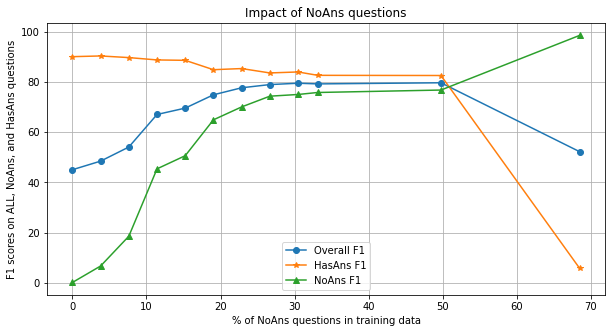

In [0]:
overall_f1 = [45.08, 48.50, 54.10, 67.04, 69.57, 74.86, 77.65, 78.92, 79.46, 79.19,
              79.64, 52.23]
has_ans_f1 = [90.02, 90.30, 89.65, 88.72, 88.56, 84.84, 85.29, 83.55, 83.94, 82.60,
              82.53, 5.84]
no_ans_f1 =  [0.27,  6.81,  18.65, 45.43, 50.65, 64.91, 70.04, 74.31, 74.99, 75.78,
              76.75, 98.49]

no_ans_questions = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 43498,  ]

tq = 1313.09
no_ans_questions_perc = [0/tq, 5000/tq, 10000/tq, 15000/tq, 20000/tq, 25000/tq, 30000/tq, 35000/tq, 40000/tq, 43498/tq,
                         4349800 * 2 / (43498 + 131309), 4349800/(43498+20000)]

plt.figure(figsize=(10, 5))
plt.plot(no_ans_questions_perc, overall_f1, label=overall_f1, marker='o')
plt.plot(no_ans_questions_perc, has_ans_f1, label=has_ans_f1, marker="*")
plt.plot(no_ans_questions_perc, no_ans_f1, label=has_ans_f1, marker="^")

plt.grid(True) 
plt.xlabel("% of NoAns questions in training data")
plt.ylabel("F1 scores on ALL, NoAns, and HasAns questions") 
plt.title("Impact of NoAns questions") 
plt.legend(["Overall F1", "HasAns F1", "NoAns F1"])
plt.show()